# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>

In [5]:
# %pip install iterative-stratification

from tensorflow.keras import mixed_precision 
import os
import gc
import ctypes

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense,GlobalAveragePooling1D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                      CSVLogger, EarlyStopping)
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from collections import Counter
from typing import Tuple, Optional, Callable
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.utils import Sequence
import pandas as pd 



### <b><span style='color:#A51C30'> 1.1 </span> GPU Dtype</b> 

- **`P100 GPU`**: For High Performance Computing(HPC)
- **`T4 GPU`**: For Deep Learning and AI tasks

### <b><span style='color:#A51C30'> 1.3 </span> New Chain</b> 

![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F16438831%2Fee75fb2b76b12fda5c559504eacc09b8%2FCentral.PNG?generation=1708318428173795&alt=media)

### <b><span style='color:#A51C30'> 1.4 </span> Updated!</b> 

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color:##A51C30; font-size:100%;">
    
📌 **`VER1`**: Original Chain, 0~30Hz, [4Waveblcok + 1GRU] 
    
📌 **`VER2`**: Adding Central[Cz,Fz,C4,C3], 0~30Hz, 


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'>2 |</span></b> <b>GPUs Setting</b></div>

In [ ]:
VER = 2

import os
import gc
import ctypes

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('tensorflow version:',tf.__version__)

# CUDA 0,1
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

# gpu strategy
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <= 1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} gpus')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} gpus')
    
# warning filtering
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# mixed_preicision
# Helps memeory effectively 

MIX=True

if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print("Mixed Precision Enabled")
else:
    print("Using Full Precision")

**Clean Memory**

In [6]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

OSError: dlopen(libc.so.6, 0x0006): tried: '/Users/tahsplique/anaconda3/lib/python3.11/lib-dynload/../../libc.so.6' (no such file), '/Users/tahsplique/anaconda3/bin/../lib/libc.so.6' (no such file), 'libc.so.6' (no such file), '/usr/local/lib/libc.so.6' (no such file), '/usr/lib/libc.so.6' (no such file), '/Users/tahsplique/Desktop/EEG_classification/libc.so.6' (no such file)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'>3 |</span></b> <b>Load Train Data</b></div>

In [7]:
# train = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
train=pd.read_csv('/Users/tahsplique/Desktop/EEG_classification/hms-harmful-brain-activity-classification/train.csv')
print('train shape: ',train.shape)
display(train.head())

train shape:  (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


### <b><span style='color:#A51C30'> 3.1 </span> Raw EEG Signals</b>

In [ ]:
New_Chain = True

In [8]:
# df = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')
df=pd.read_parquet('/Users/tahsplique/Desktop/EEG_classification/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features')
print(list(FEATS))

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [9]:
if New_Chain: 
    print('We will use the follwing subset of 10 raw eeg features:')
    FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2','Fz', 'Pz']
    FEAT2IDX = {x:y for x,y in zip(FEATS, range(len(FEATS)))}
    print(FEATS)

NameError: name 'New_Chain' is not defined

In [10]:
def eeg_from_parquet(parquet_path, display=False):
    
    # 특정 electrode만 추출하기
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-10000)//2
    # eeg의 구간: 50초
    eeg = eeg.iloc[offset:offset+10_000]
    
    if display:
        plt.figure(figsize=(10,5))
        offset = 0
        
    # CONVERT TO NUMPY
    data = np.zeros((10_000, len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
            
        data[:,j] = x    
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(10_000), x-offset, label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}', size=16)
        plt.show()
        
    return data    

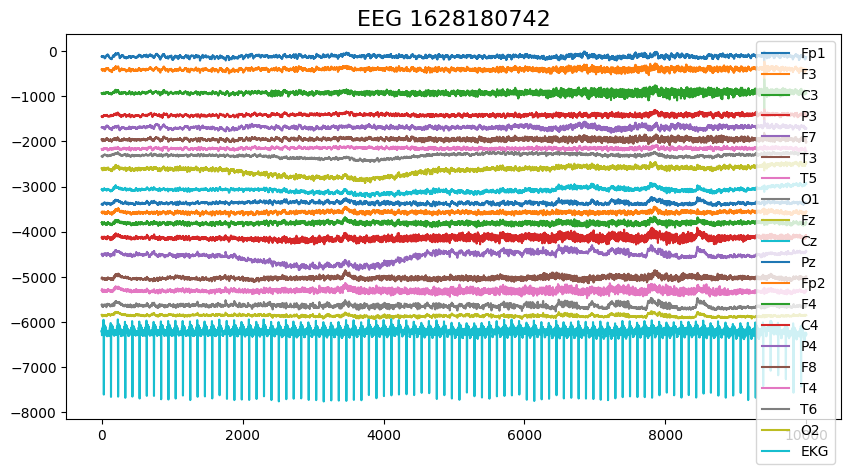

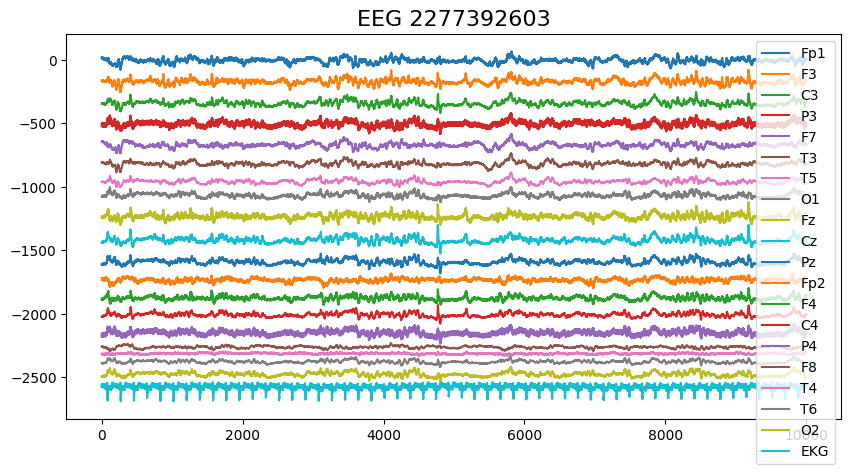

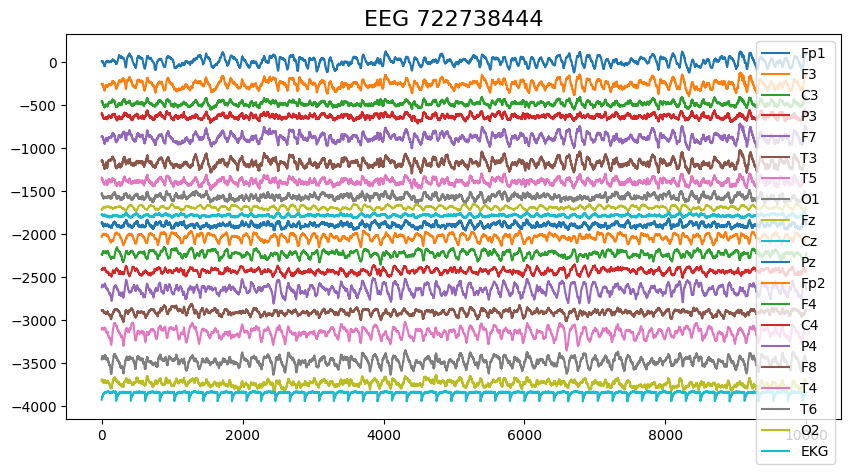

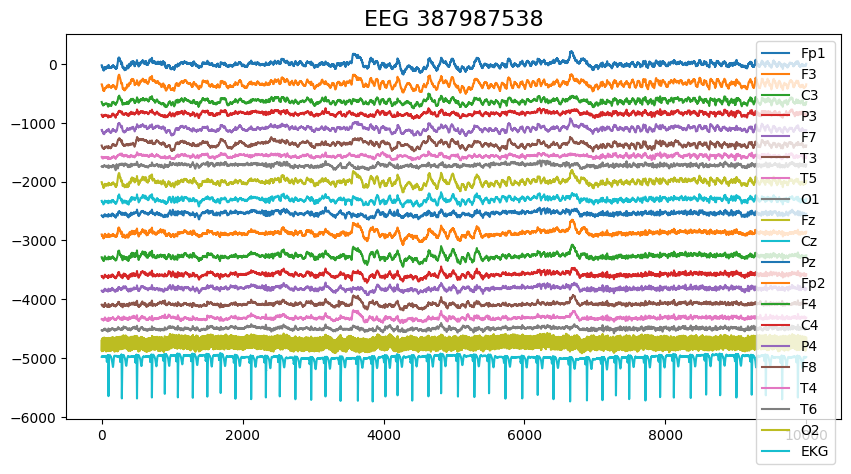

Reading 17089 eeg Numpys from disk.


NameError: name 'New_Chain' is not defined

In [12]:
%%time

CREATE_EEGS = False
all_eegs = {}
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
# PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
PATH='/Users/tahsplique/Desktop/EEG_classification/hms-harmful-brain-activity-classification/train_eegs/'

for i, eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i, ', ', end='')
        
    data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY) 
    all_eegs[eeg_id] = data
    
    if i==DISPLAY:
        if CREATE_EEGS:
            print(f'processing {train.eeg_id.nunique()} eeg parquets... ', end='')
        else:
            print(f'Reading {len(EEG_IDS)} eeg Numpys from disk.')
            
            break

if New_Chain:   
    all_eegs = np.load('/kaggle/input/central-part/eegs.npy',allow_pickle=True).item()  

In [17]:
#remove EKG signal from the data
def remove_ekg(data):
     data[:, :-1] = data[:, :-1] - data[:, -1:]
     return data
     

for eeg_id in all_eegs:
    all_eegs[eeg_id] = remove_ekg(all_eegs[eeg_id])

### <b><span style='color:#A51C30'> 3.2 </span> Deduplicate Train EEG Id</b>

In [19]:
# LOAD TRAIN 
# df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
df=pd.read_csv('/Users/tahsplique/Desktop/EEG_classification/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

train = df.groupby('eeg_id')[['patient_id']].agg('first')

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
train = train.loc[train.eeg_id.isin(EEG_IDS)]
print('Train Data with unique eeg_id shape:', train.shape )
train.head()

Train Data with unique eeg_id shape: (17089, 9)


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


**Expert_Agreement**

### <b><span style='color:#A51C30'> 3.3 </span> Butter Low-Pass Filter[0~30Hz]</b>

In [20]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq=30, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

def butter_highpass_filter(data, cutoff_freq=0.1, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data



### <b><span style='color:#A51C30'> 3.4 </span> Wavelet Denoising[db8]</b>

In [22]:
import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = 'db8'

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [23]:
# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

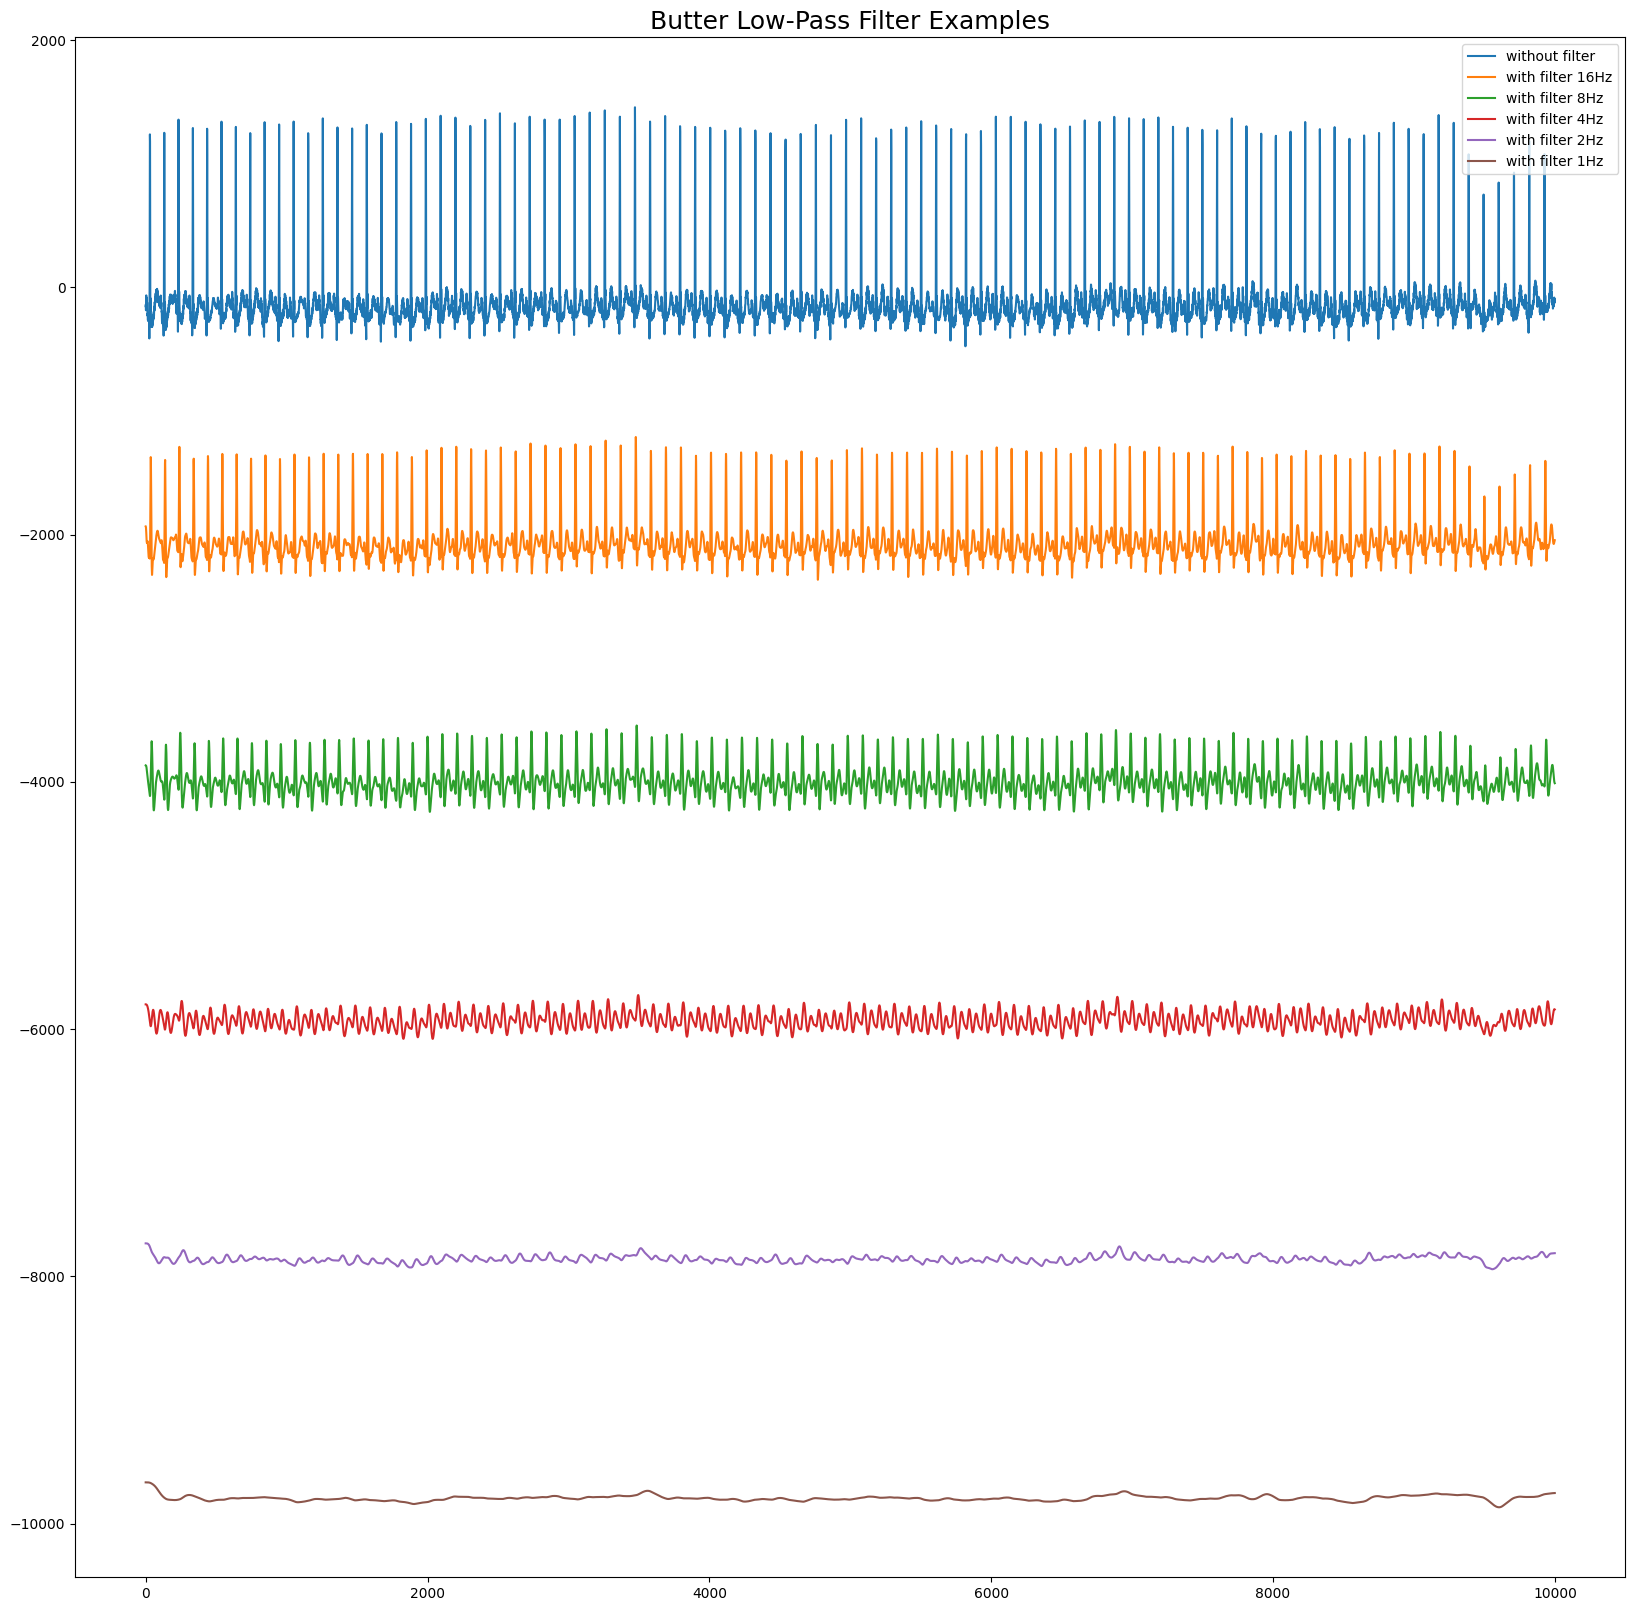

In [24]:
FREQS = [1,2,4,8,16][::-1]
x = [all_eegs[EEG_IDS[0]][:,0]]
for k in FREQS:
    x.append( butter_lowpass_filter(x[0], cutoff_freq=k) )

plt.figure(figsize=(20,20))
plt.plot(range(10_000),x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {FREQS[k-1]}Hz')
plt.legend()
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'>4 |</span></b> <b>Data Loader</b></div>

In [ ]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    # Constructor(init method)
    def __init__(self,data, batch_size=32, shuffle=True, eegs=all_eegs,
               mode='train', downsample=5,):
        
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs 
        self.mode = mode
        self.downsample = downsample
        self.on_epoch_end()
        
    def __len__(self):
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
        
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X[:,::self.downsample,:], y
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        # New chain change 8 -> 10
        X = np.zeros((len(indexes),10_000,10), dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        
        sample = np.zeros((10_000, X.shape[-1]))
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            data = self.eegs[row.eeg_id] 
            
            # FEATURE ENGINEER
            sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
            sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
            sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
            sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]
            
            sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
            sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]
            
            sample[:,8] = data[:,FEAT2IDX['Fz']] - data[:,FEAT2IDX['Pz']]
            sample[:,9] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['C4']]
            
            
            # crop scaling
            sample = np.clip(sample, -1024,1024)

            
            # standarization: (x-mean)/std
            # The mean of all the raw data: 0
            # The std of all the raw data: 32
            sample = np.nan_to_num(sample,nan=0) / 32.0
            
            # BUTTER LOW-PASS FILTER[0~30Hz]
            sample = butter_lowpass_filter(sample)
            
            # BUTTER HIGH-PASS FILTER[0.1~]
            sample = butter_highpass_filter(sample)
            
            # Wavelet Filtering[db6]
            sample = denoise(sample,wavelet=USE_WAVELET)
        
            X[j,] = sample
            if self.mode!= 'test':
                y[j] = row[TARGETS]
                
        return X,y
    

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'>5 |</span></b> <b>Resnet18</b></div>

In [ ]:
# TRAIN SCHEDULE

def lrfn(epoch):
    return [1e-3,1e-3,1e-4,1e-4,1e-5][epoch]
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
EPOCHS = 5



class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x.astype(np.float32), batch_y #makes sure output isin float32
    
    
class CleanMemory(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

    
class ResetLR(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    default_lr = 0.1
    previous_lr = self.model.optimizer.lr.read_value()
    if previous_lr!=0.01:
      print("Resetting learning rate from {} to {}".format(previous_lr, default_lr))
      self.model.optimizer.lr.assign(default_lr)

class ReduceLRBacktrack(ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

In [ ]:

from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense,GlobalAveragePooling1D)
from tensorflow.keras.models import Model
import numpy as np
import os



class ResidualUnit(object):
    """Residual unit block (unidimensional).
    Parameters
    ----------
    n_samples_out: int
        Number of output samples.
    n_filters_out: int
        Number of output filters.
    kernel_initializer: str, optional
        Initializer for the weights matrices. See Keras initializers. By default it uses
        'he_normal'.
    dropout_keep_prob: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. Default is 17.
    preactivation: bool, optional
        When preactivation is true use full preactivation architecture proposed
        in [1]. Otherwise, use architecture proposed in the original ResNet
        paper [2]. By default it is true.
    postactivation_bn: bool, optional
        Defines if you use batch normalization before or after the activation layer (there
        seems to be some advantages in some cases:
        https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md).
        If true, the batch normalization is used before the activation
        function, otherwise the activation comes first, as it is usually done.
        By default it is false.
    activation_function: string, optional
        Keras activation function to be used. By default 'relu'.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027 [cs], Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_keep_prob=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = 1 - dropout_keep_prob
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1]
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2]
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


def get_model2(n_classes, last_layer='softmax'): #try with softmax 'sigmoid' initially
    kernel_size = 16 
    kernel_initializer = 'he_normal'
    signal = Input(shape=(10000, 20), dtype=np.float32, name='signal') #change to my input size 2500,12
 #change to my input size 2500,12
    x = signal
    x = Conv1D(64, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x, y = ResidualUnit(1024, 128, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, x])
    x, y = ResidualUnit(256, 196, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, y = ResidualUnit(64, 256, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, _ = ResidualUnit(16, 320, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    # x=GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    diagn = Dense(n_classes, activation=last_layer, kernel_initializer=kernel_initializer, dtype='float32')(x)
    # diagn=GlobalAveragePooling1D()(x)

    model = Model(signal, diagn)
    return model


model = get_model2(6)
model.summary()


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'>6 |</span></b> <b>Cross Validation</b></div>

### <b><span style='color:#A51C30'> 6.1 </span> Train GroupKFold</b>

In [ ]:
out_dir='/kaggle/working'


TRAIN_MODEL = True      
FOLDS_TO_TRAIN = 5
config= {'epochs':50, 'learning_rate':0.01, 'batch_size': 256}

from sklearn.model_selection import GroupKFold
import tensorflow.keras.backend as K, gc 

all_oof = [] ; all_true = [] 

gkf = GroupKFold(n_splits=5)
for i, (train_idx, valid_idx) in enumerate(gkf.split(train, train.target, train.patient_id)):
    
    # 진행상태 확인하기 
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_idx)}, valid size {len(valid_idx)}')
    print('#'*25)  
          
    # split train & valid       
    train_gen = DataGenerator(train.iloc[train_idx], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_idx], shuffle=False, batch_size=64)
    
    # model 정의
    # WaveNet Model은 이미 function으로 정함
    K.clear_session()
    with strategy.scope():
        model = get_model2()
        model.compile(loss=loss, optimizer=opt, metrics=['accuracy', #remplacer par tes metriques
                                                                tf.keras.metrics.CategoricalAccuracy(name='acc'),
                                                                #  tf.keras.metrics.AUC(curve='ROC', name='ROC'),
                                                                #  tf.keras.metrics.AUC(curve='PR', name='PR')
                                                                ], run_eagerly=False)

           
          
    # moodel fit
    if TRAIN_MODEL:
        lr = config['learning_rate']
        opt = Adam(lr)
        opt = mixed_precision.LossScaleOptimizer(opt)  
        loss = tf.keras.losses.KLDivergence()
        
        
        callbacks = [ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=7,
                               min_lr=lr / 100),
             EarlyStopping(patience=9,  # Patience should be larger than the one in ReduceLROnPlateau
                           min_delta=0.00001)]
        
        model.compile(loss=loss, optimizer=opt, metrics='accuracy')#remplacer par tes metriques

        model.fit(train_gen, verbose=1,
               validation_data = valid_gen, 
              epochs=EPOCHS,
              callbacks=callbacks,
              validation_data=valid_gen,)
        
        
        c1 = ModelCheckpoint(os.path.join(out_dir,'{}_benchmark/'.format(condition_name), 'best_model.h5'), 
                    save_best_only=False,
                    save_weights_on=True,
                    monitor='val_loss')
        
        
        
        callbacks +=[CleanMemory(),c1]
        callbacks += [TensorBoard(log_dir='./logs', write_graph=False),
                 CSVLogger('training.log', append=False)]  # Change append to true if continuing training
        
    
         
    # model save
    # save_weights는 tf.keras에서 지원하는 기능
        # model.save_weights(f'{directory_path}resnet18{i}.h5')
                           
    # model predict
    oof = model.predict(valid_gen, verbose=False) 
    all_oof.append(oof)
    all_true.append(train.iloc[valid_idx][TARGETS].values)
                           
    if i == FOLDS_TO_TRAIN-1: break     
                           
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)


del model
# del early_stop
# del lrplateau
# tf.keras.clear_session()
gc.collect()

In [ ]:
del oof, train_gen, valid_gen
clean_memory()

### <b><span style='color:#A51C30'> 6.2 </span> CV Score</b>

In [ ]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'>7 |</span></b> <b>Submit to Kaggle LB</b></div>

In [ ]:
del all_eegs, train; gc.collect()
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)
test.head()

In [ ]:
all_eegs2 = {}
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

print('Processing Test EEG parquets...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = data

In [ ]:
# INFER MLP ON TEST
preds = []
model = get_model2()
test_gen = DataGenerator(test, shuffle=False, batch_size=64, eegs=all_eegs2, mode='test')

print('Inferring test... ',end='')
for i in range(FOLDS_TO_TRAIN):
    print(f'fold {i+1}, ',end='')
    if TRAIN_MODEL:
        model.load_weights(f'WaveNet_Model/WaveNet_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/brain-eegs/WaveNet_Model/WaveNet_fold{i}.h5')
    pred = model.predict(test_gen, verbose=0)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

In [ ]:
# # CREATE SUBMISSION.CSV
# from IPython.display import display

# sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
# sub[TARGETS] = pred
# sub.to_csv('submission.csv',index=False)
# print('Submission shape',sub.shape)
# display( sub.head() )

# # SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
# print('Sub row 0 sums to:',sub.iloc[0,-6:].sum())